In [2]:
from hydra.core.global_hydra import GlobalHydra
from hydra import initialize_config_dir, compose
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import json
import random
import os

# Initialize Hydra with the config path
GlobalHydra.instance().clear()
initialize_config_dir(config_dir="/home/ta-tldr/Project/tldr/config/", version_base=None)
cfg = compose(config_name="TrafficQA.yaml")
dataset_root = cfg.TrafficQA.dataset_root
video_root = dataset_root + "raw_videos/"

# per_token = True
per_token = False

# load csv file
df_info = pd.read_csv(Path(dataset_root, "csv", "response_mutual_info_text_task_new4.csv"), delimiter="|")
df_comp = pd.read_csv(Path(dataset_root, "csv", "response_mutual_info_video_text_new4.csv"), delimiter="|")
CoT_df_info = pd.read_csv(Path(dataset_root, "csv", "CoT_mutual_info_text_task.csv"), delimiter="|")
CoT_df_comp = pd.read_csv(Path(dataset_root, "csv", "CoT_mutual_info_video_text.csv"), delimiter="|")

# read in response data
cot_responses_df = pd.read_csv('/nas/pohan/datasets/SUTDTrafficQA/csv/vlm_CoT.csv', delimiter='|')
vlm_responses_df = pd.read_csv('/nas/pohan/datasets/SUTDTrafficQA/csv/vlm_responses_new4.csv', delimiter='|')

# Read dataset annotations
traffic_dataset = pd.read_json('/nas/pohan/datasets/SUTDTrafficQA/annotations/R2_all.jsonl', lines=True)
traffic_dataset = pd.DataFrame(traffic_dataset.values[1:], columns=traffic_dataset.iloc[0]) # use first row as header

In [3]:
# Filter out rows with -10 in logprob_text or logprob
def filter_logprob(df_info, threshold=-10):
    return set(df_info[(df_info['logprob_text'] > threshold) & (df_info['logprob'] > threshold)]['record_id'])

# Apply the function to each dataframe
filtered_record_ids = (filter_logprob(df_info) & filter_logprob(CoT_df_info))
df_info_filtered = df_info[df_info['record_id'].isin(filtered_record_ids)]
CoT_info_filtered = CoT_df_info[CoT_df_info['record_id'].isin(filtered_record_ids)]

## sample 10 here

In [4]:
# Get videos with at least 4 unique record_ids
video_counts = df_info_filtered.groupby('vid_filename')['record_id'].nunique()
eligible_videos = video_counts[video_counts >= 4].index.tolist()
print(f"eligible videos: {len(eligible_videos)}")

# sample 10 videos from the eligible videos
# sampled_ids = eligible_videos
# random.seed(42)  # For reproducibility
# sampled_ids = random.sample(eligible_videos, min(10, len(eligible_videos)))
# print(f"sampled {len(sampled_ids)} videos: {sampled_ids}")
# sampled_vids = [df_info_filtered[df_info_filtered['vid_filename'] == video]['video_id'].values[0] for video in sampled_ids]

# sampled_vids = [5285, 6665, 6109, 6577, 9302, 9521, 10435, 17846, 18542, 19199, 21163, 23046, 23318]     # list of 13 hand-inspected to be okay
sampled_vids = [17846, 23046, 9302, 9521, 10435, 19199, 21163, 5285, 23318, 6665]    # chosen 10 videos from the list of 13 (6109, 6577 bad)
print(f"sampled {len(sampled_vids)} vids: {sampled_vids}")


# find the record_ids that are in the sampled_vids
sampled_record_ids = df_info_filtered[df_info_filtered['video_id'].isin(sampled_vids)]['record_id'].unique()
print(f"sampled {len(sampled_record_ids)} record_ids")


eligible videos: 88
sampled 10 vids: [17846, 23046, 9302, 9521, 10435, 19199, 21163, 5285, 23318, 6665]
sampled 40 record_ids


In [5]:
def calculate_tldr_scores(df_info, filtered_record_ids):
    log_info_scores = []
    info_ranks = []
    for record_id in filtered_record_ids:
        row = df_info[df_info['record_id'] == record_id]
        # print(row)
        info_score = row['informativeness_score'].values[0]
        log_info_scores.append(info_score)
        info_ranks.append(row["logprob_text"].values[0] - row["logprob"].values[0])
    return log_info_scores, info_ranks

log_info_scores, info_ranks = calculate_tldr_scores(df_info_filtered, sampled_record_ids)
CoT_log_info_scores, CoT_info_ranks = calculate_tldr_scores(CoT_info_filtered, sampled_record_ids)

In [6]:
# only keep the rows that are in the sampled_record_ids
df_info_filtered = df_info_filtered[df_info_filtered['video_id'].isin(sampled_vids)]
CoT_info_filtered = CoT_info_filtered[CoT_info_filtered['video_id'].isin(sampled_vids)]
df_comp = df_comp[df_comp['video_id'].isin(sampled_vids)]
CoT_df_comp = CoT_df_comp[CoT_df_comp['video_id'].isin(sampled_vids)]

In [7]:
def initialize_dataframe():
    columns = ['video_id', 'group', 'predicted_word_video', 'predicted_word', 'orig_word', 'complexity_score', 'rank_video', 'rank']
    dtypes = {
        'video_id': 'int', 
        'group': 'object',
        'predicted_word_video': 'object',
        'predicted_word': 'object',        
        'orig_word': 'object',             
        'complexity_score': 'float', 
        'rank_video': 'object',            
        'rank': 'object'                   
    }
    return pd.DataFrame(columns=columns).astype(dtypes)

def process_data(df_info_filtered, df_comp):
    df_comp_total = initialize_dataframe()
    log_comp_scores = []
    comp_ranks = []
    max_id, min_id = None, None
    max_diff, min_diff = -100, 100
    num_tokens = []
    # Filter out rows with -10 in logprob_video or logprob
    for video_id in df_info_filtered['video_id'].unique():
        for group in df_comp['group'].unique():
            row = df_comp[(df_comp['video_id'] == video_id) & (df_comp['group'] == group)]
            if per_token:
                diff_count = len(row)
            else:
                diff_count = 1  # Placeholder value
            diff = row['diff'].sum()
            if diff == 0:
                print(f"Diff is 0 for video_id: {video_id}, group: {group}. This might be due to no video.")
                comp_ranks.append(0)
                num_tokens.append(1)
            else:
                log_comp_scores.append(diff / diff_count)
                comp_ranks.append(row['logprob_video'].values[0] - row['logprob'].values[0])
                num_tokens.append(diff_count)
                
            if diff > max_diff:
                max_diff = diff
                max_id = video_id
            if diff < min_diff:
                min_diff = diff
                min_id = video_id
            
            new_row = pd.DataFrame({
                'video_id': [video_id], 
                'group': [group],
                'predicted_word_video': [row['predicted_word_video'].values], 
                'predicted_word': [row['predicted_word'].values], 
                'orig_word': [row['orig_word'].values], 
                'complexity_score': [diff / diff_count], 
                'rank_video': [row['rank_video'].values], 
                'rank': [row['rank'].values]
            })
            df_comp_total = pd.concat([df_comp_total, new_row], ignore_index=True)
    
    return df_comp_total, log_comp_scores, comp_ranks, max_id, min_id, num_tokens


# Process data
df_comp_total, log_comp_scores, comp_ranks, max_id, min_id, num_tokens = process_data(df_info_filtered, df_comp)
CoT_df_comp_total, CoT_log_comp_scores, CoT_comp_ranks, CoT_max_id, CoT_min_id, CoT_num_tokens = process_data(df_info_filtered, CoT_df_comp)

print(f"Max complexity id: {max_id}, Min complexity id: {min_id}")
print(f"Max CoT complexity id: {CoT_max_id}, Min CoT complexity id: {CoT_min_id}")
print(f"Avg num of tokens: {sum(num_tokens) / len(num_tokens)}")

Max complexity id: 23318, Min complexity id: 17846
Max CoT complexity id: 23046, Min CoT complexity id: 5285
Avg num of tokens: 1.0


In [8]:
# Add a 'group' column to each DataFrame before concatenation
merged_info_df = df_info_filtered.copy().drop(columns=["predicted_answer_text", "predicted_answer"])

# Sort the merged DataFrame by 'video_id'
merged_info_df = merged_info_df.sort_values(by=['record_id', 'group'])

# print(f"merged_info_df shape: {merged_info_df.shape}")
# print(merged_info_df.head())

# Create a new DataFrame with selected columns
merge_record_info_df = pd.DataFrame({
    'video_id': pd.Series(dtype='int'),
    'group': pd.Series(dtype='object'),
    'max_informativeness_score': pd.Series(dtype='float64'),
    'min_informativeness_score': pd.Series(dtype='float64'),
    'informativeness_score': pd.Series(dtype='float64')
})

cnt = 0
for video_id in merged_info_df['video_id'].unique():
    for group in merged_info_df['group'].unique():
        row = merged_info_df[(merged_info_df['video_id'] == video_id) & (merged_info_df['group'] == group)]
        if not row.empty:
            merge_record_info_df.at[cnt, 'video_id'] = int(video_id)
            merge_record_info_df.at[cnt, 'group'] = group
            merge_record_info_df.at[cnt, 'max_informativeness_score'] = max(row['informativeness_score'].values)
            merge_record_info_df.at[cnt, 'min_informativeness_score'] = min(row['informativeness_score'].values)
            merge_record_info_df.at[cnt, 'informativeness_score'] = sum(row['informativeness_score'].values) / len(row['informativeness_score'].values)
            cnt += 1

merge_record_info_df = merge_record_info_df.sort_values(by=['video_id', 'group'])
merge_record_info_df['video_id'] = merge_record_info_df['video_id'].astype(int)
print(f"new_info_df shape: {merge_record_info_df.shape}\n")
merge_record_info_df.head()

new_info_df shape: (50, 5)



,video_id,group,max_informativeness_score,min_informativeness_score,informativeness_score
45,5285,temperature_0.0,1.078006,0.071116,0.732929
46,5285,temperature_0.5,1.078579,0.109448,0.696512
47,5285,temperature_1.0,1.068251,0.109468,0.760413
48,5285,temperature_1.25,1.073376,0.109469,0.757670
49,5285,temperature_1.5,1.077716,0.056700,0.647880


In [9]:
# then concatenate as before
merged_complexity_df = df_comp_total.sort_values(by=['video_id', 'group'])
merged_complexity_df.drop(columns=['predicted_word_video', 'predicted_word', 'orig_word', 'rank_video', 'rank'], inplace=True)
print(f"merged_complexity_df shape: {merged_complexity_df.shape}")
merged_complexity_df.head()

merged_complexity_df shape: (50, 3)


,video_id,group,complexity_score
0,5285,temperature_0.0,8.703312
1,5285,temperature_0.5,11.808859
2,5285,temperature_1.0,5.789427
3,5285,temperature_1.25,3.973962
4,5285,temperature_1.5,9.964131


In [10]:
# merge the rows of the two dataframes with the same video_id and group
ib_df = pd.merge(merged_complexity_df, merge_record_info_df, on=['video_id', 'group'], how='inner')
ib_df = ib_df.sort_values(['video_id', 'group'], ascending=True)

# create a new column for the informativeness score difference for each beta
alpha_betas = [(1, 0), (-1, 0), (0, 1)]
alpha_betas += [(-0.02, 1), (-0.05, 1), (-0.1, 1), (-0.3, 1)]
alpha_betas += [(0.02, 1), (0.05, 1), (0.1, 1), (0.3, 1)]
max_ib_dfs = []
max_ib_labels = []
for idx, ab in enumerate(alpha_betas):
    a, b = ab
    max_ib_labels.append(f'Max IB ($\\alpha,\\beta=({a},{b})$)')
    ib_df[f'ib_score_beta_{ab}'] = a * ib_df['complexity_score'] + b * ib_df['informativeness_score']
    # ascending=False to get the max score
    max_ib_dfs.append(ib_df.sort_values(f'ib_score_beta_{ab}', ascending=False).drop_duplicates('video_id').reset_index(drop=True))
    ib_df.drop(columns=[f'ib_score_beta_{ab}'], inplace=True)
print(max_ib_dfs[-1].shape)
print(max_ib_dfs[-1].head())

# randomly sample ib scores
random.seed(42)
ib_df["random_score"] = np.random.randint(0, 1000, len(ib_df))
# ascending=False to get the max score
max_ib_dfs.append(ib_df.sort_values('random_score', ascending=False).drop_duplicates('video_id').reset_index(drop=True))
ib_df.drop(columns=['random_score'], inplace=True)

(10, 7)
   video_id             group  complexity_score  max_informativeness_score  \
0      9302  temperature_1.25         20.735365                   2.087938   
1     23046   temperature_0.0         13.970056                   1.119864   
2     23318   temperature_0.0         20.792721                   0.258648   
3     10435   temperature_0.5         12.254457                   2.845299   
4      5285   temperature_0.5         11.808859                   1.078579   

   min_informativeness_score  informativeness_score  ib_score_beta_(0.3, 1)  
0                  -0.646038               0.407264                6.627873  
1                  -0.724933               0.567093                4.758110  
2                  -6.707847              -1.597508                4.640308  
3                   0.049161               0.772384                4.448721  
4                   0.109448               0.696512                4.239170  


In [11]:
visible = {
    # 'TLDR': True,
    # 'Abstract': True,
    # 'VLM (Aware)': True,
    # 'VLM (Agnostic)': True,
    'CoT': True
}
for label in max_ib_labels:
    visible[label] = True
visible["random"] = True

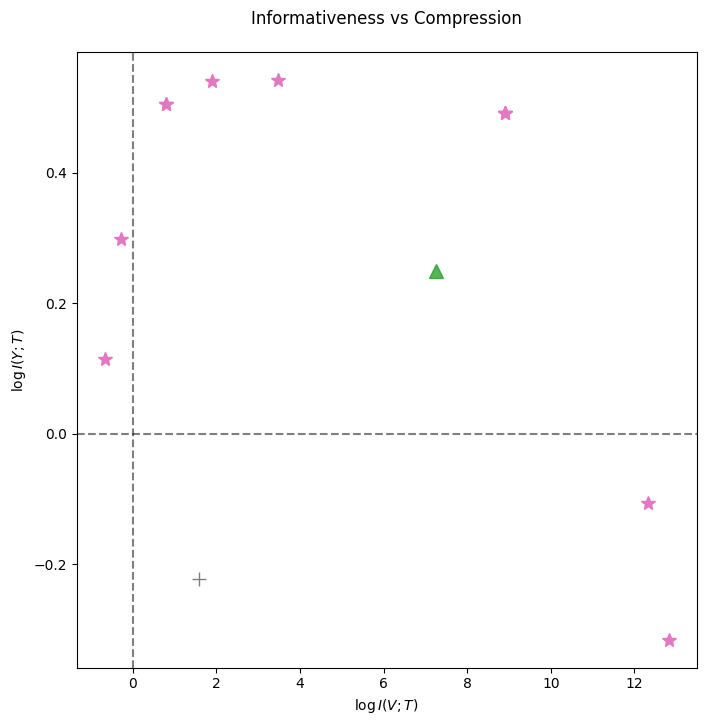

In [12]:
# Create a figure for the main scatter plot
fig, scatter_ax = plt.subplots(figsize=(8, 8))

# Create a custom color palette for better distinction
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b', '#d62728', '#e377c2', '#7f7f7f']
markers = ['o', 's', '^', 'd', 'x', 'P', '*', '+']
opacity = [0.8, 0.8, 0.8, 0.8, 1, 1, 1, 1]

# Function to filter data by video_ids if provided
def filter_data_by_video_ids(data, video_ids=None):
    if video_ids is not None:
        return data[data['video_id'].isin(video_ids)]
    return data

# Define function to create plot with optional video_id filtering
def create_plot(ax, video_ids=None):
    # Initialize data_groups dictionary
    data_groups = {}
    
    # CoT data
    data_groups['CoT'] = {
        'x': CoT_log_comp_scores,
        'y': CoT_log_info_scores,
        'color': colors[2],
        'marker': markers[2],
        'alpha': opacity[2]
    }
    
    for idx, label in enumerate(max_ib_labels):
        filtered_df = filter_data_by_video_ids(max_ib_dfs[idx], video_ids)
        data_groups[label] = {
            'x': filtered_df['complexity_score'],
            'y': filtered_df['informativeness_score'],
            'color': colors[6],
            'marker': markers[6],
            'alpha': opacity[6]
        }
    
    filtered_random_df = filter_data_by_video_ids(max_ib_dfs[-1], video_ids)
    data_groups["random"] = {
            'x': filtered_random_df['complexity_score'],
            'y': filtered_random_df['informativeness_score'],
            'color': colors[7],
            'marker': markers[7],
            'alpha': opacity[7]
        }

    # Clear previous plot
    ax.clear()
    
    # Create scatter plots and error bars for each group
    ib_legend = False
    for label, group_data in data_groups.items():
        if label == 'CoT':
            label_latex = "VLM (CoT)"
        elif label == 'random':
            label_latex = "Random Sampling"
        elif "Max IB" in label and not ib_legend:
            label_latex = "IB, $(\\alpha, \\beta)$=["
            for idx, ab in enumerate(alpha_betas):
                label_latex += f"{ab},"
                if idx % 4 == 3:
                    label_latex += '\n'
            label_latex += "] (ours)"
            ib_legend = True
        else:
            label_latex = ""

        # Main scatter plot with error bars
        if visible[label] and len(group_data['x']) > 0:
            ax.errorbar(
                np.mean(group_data['x']), np.mean(group_data['y']),
                fmt=group_data['marker'], color=group_data['color'], 
                elinewidth=1.5, capsize=8, alpha=group_data['alpha'], label=label_latex,
                markersize=10  # Increased marker size
            )

    # Add x=0 and y=0 lines
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('$\log I(V;T)$ ')  # Negative complexity score
    ax.set_ylabel('$\log I(Y;T)$ ')  # Informativeness score
    ax.set_title('Informativeness vs Compression', pad=20)

    # Add a vertical arrow pointing upwards with text above it
    ax.annotate('More\nInformative',
                        xy=(3.5, 3.75),  # Arrow tip
                        xytext=(3.5, 1.5),  # Arrow tail (lower position for upward direction)
                        arrowprops=dict(color='black', arrowstyle='-|>', lw=2),
                        fontsize=10, color='red',
                        ha='center',  # Center text horizontally
                        va='bottom')  # Ensure text is above the arrow

    # Add a horizontal arrow pointing left with text above it
    ax.annotate('More Grounded to Video',
                        xy=(30, 3.5),  # Arrow tip (further left)
                        xytext=(15, 3.5),  # Arrow tail (even further left)
                        arrowprops=dict(color='black', arrowstyle='-|>', lw=2),
                        fontsize=10, color='red',
                        ha='center',  # Align text to the right (places it left of the arrow)
                        va='center')  # Vertically center the text

    # Add legend
    # ax.legend(frameon=True, framealpha=0.9, loc='best')
    
    return fig

# Create the initial plot with all data
create_plot(scatter_ax)
plt.show()

### Length vs. Informativeness

In [13]:
# load response length data
length_df = pd.read_csv(Path(dataset_root, "csv", "vlm_response_length.csv")) #.drop(columns=["response"])
CoT_length_df = pd.read_csv(Path(dataset_root, "csv", "vlm_CoT_length.csv")) #.drop(columns=["response"])
# IB filtering
length_ib_dfs = []
for idx, ab in enumerate(alpha_betas):
    length_df = pd.merge(length_df, max_ib_dfs[idx][['video_id', f'ib_score_beta_{ab}']], on='video_id', how='inner')
    length_ib_dfs.append(length_df.sort_values(f'ib_score_beta_{ab}', ascending=False).drop_duplicates('video_id').reset_index(drop=True))
    length_df.drop(columns=[f'ib_score_beta_{ab}'], inplace=True)

In [14]:
# save the best responses of each openreview ID according to the following criteria:
# 1. max informativeness score
# 2. max complexity score
# 3. min informativeness score
# 4. min complexity score


# Save the best responses based on the criteria
best_responses = {}

# 1. Max informativeness score
best_responses['max_informativeness'] = merged_info_df.loc[
    merged_info_df.groupby('video_id')['informativeness_score'].idxmax()
].drop(columns=['correct_answer', 'logprob_text', 'logprob', 'rank_text', 'rank'])

# 2. Max complexity score
best_responses['max_complexity'] = merged_complexity_df.loc[
    merged_complexity_df.groupby('video_id')['complexity_score'].idxmax()
]

# 3. Min informativeness score
best_responses['min_informativeness'] = merged_info_df.loc[
    merged_info_df.groupby('video_id')['informativeness_score'].idxmin()
].drop(columns=['correct_answer', 'logprob_text', 'logprob', 'rank_text', 'rank'])

# 4. Min complexity score
best_responses['min_complexity'] = merged_complexity_df.loc[
    merged_complexity_df.groupby('video_id')['complexity_score'].idxmin()
]

print("Best responses based on criteria:")
print("Max Informativeness:\n", best_responses["max_informativeness"].head())
print("Max Complexity:\n", best_responses["max_complexity"].head())
print("Min Informativeness:\n", best_responses["min_informativeness"].head())
print("Min Complexity:\n", best_responses["min_complexity"].head())

Best responses based on criteria:
Max Informativeness:
      video_id  record_id                     vid_filename  \
187      5285      54999        b_12a4y1i7Nk_clip_043.mp4   
329      6665      25531                c_movi7951_12.mp4   
842      9302      23358  b_1EW411v73M_part2_clip_033.mp4   
450      9521       8238        b_1X7411i7Ph_clip_044.mp4   
909     10435      26219        b_1hE411p7Th_clip_010.mp4   

                  q_type            group  informativeness_score  
187  Basic Understanding  temperature_0.5               1.078579  
329  Basic Understanding  temperature_1.0               2.397873  
842  Basic Understanding  temperature_1.5               2.169042  
450  Basic Understanding  temperature_0.0               0.660739  
909  Basic Understanding  temperature_0.5               2.845299  
Max Complexity:
     video_id             group  complexity_score
1       5285   temperature_0.5         11.808859
5       6665   temperature_0.0         12.858704
13      930

In [15]:
# Add the parent directory to sys.path to make utils module accessible
import sys
sys.path.append(str(Path.cwd().parent.parent))
from utils.primary_area import subarea_map
OPTIONS = sorted(list(set(subarea_map.values())))

# save all the responses from best_responses
id2_responses_json = {}
for idx, row in length_df.iterrows():
    video_id = row['video_id']
    video_id = row['video_id']
    if video_id not in id2_responses_json:
        id2_responses_json[video_id] = {}
    for key, best_df in best_responses.items():
        group = best_df[best_df['video_id'] == video_id]['group'].values[0]
        id2_responses_json[video_id][key] = length_df[
            (length_df['video_id'] == video_id) & 
            (length_df['group'] == group)
        ]["response"].values[0]
    correct_option =  merged_info_df[
        merged_info_df['video_id'] == video_id
    ]["correct_answer"].values[0]
    correct_number = ord(correct_option) - ord('A')
    id2_responses_json[video_id]["correct_answer"] = OPTIONS[correct_number]
    id2_responses_json[video_id]['video_id'] = video_id

# save the json file
with open(Path(video_root, "best_responses.json"), 'w') as f:
    json.dump(id2_responses_json, f, indent=4)

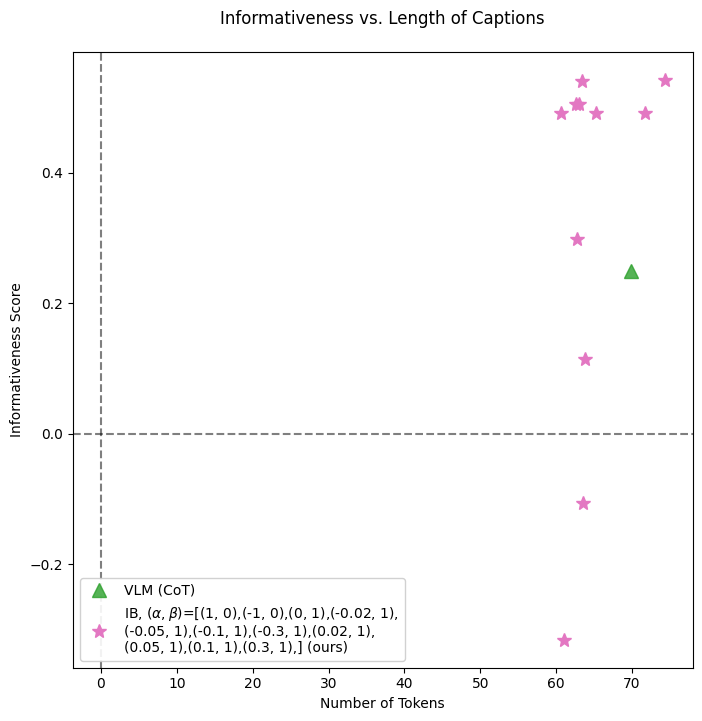

In [16]:
# Define data groups
data_groups_length = {
    'CoT': {
        'x': CoT_length_df['length'],
        'y': CoT_log_info_scores,
        'color': colors[2],
        'marker': markers[2],
        'alpha': opacity[2]
    },
}
for idx, label in enumerate(max_ib_labels):
    data_groups_length[label] = {
        'x': length_ib_dfs[idx]['length'],
        'y': max_ib_dfs[idx]['informativeness_score'],
        'color': colors[6],
        'marker': markers[6],
        'alpha': opacity[6]
    }

# Create a grid layout without space for histograms
fig, scatter_ax = plt.subplots(figsize=(8, 8))

ib_legend = False
for label, group_data in data_groups_length.items():
    if label == 'CoT':
        label_latex = "VLM (CoT)"
    elif label in ['VLM (Agnostic)', 'VLM (Aware)']:
        label_latex = label
    elif label in ['TLDR', 'Abstract']:
        label_latex = label + " (OpenReview)"
    elif "Max IB" in label and not ib_legend:
        label_latex = "IB, $(\\alpha, \\beta)$=["
        for idx, ab in enumerate(alpha_betas):
            label_latex += f"{ab},"
            if idx % 4 == 3:
                label_latex += '\n'
        label_latex += "] (ours)"
        ib_legend = True
    else:
        label_latex = ""

    # Main scatter plot
    scatter_ax.errorbar(
        np.mean(group_data['x']), np.mean(group_data['y']),
        fmt=group_data['marker'], color=group_data['color'],
        elinewidth=1.5, capsize=8, alpha=group_data['alpha'], label=label_latex,
        markersize=10  # Increased marker size
    ) if visible[label] else None

# Add x=0 and y=0 lines
scatter_ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
scatter_ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
scatter_ax.set_xlabel('Number of Tokens')
scatter_ax.set_ylabel('Informativeness Score')
scatter_ax.set_title('Informativeness vs. Length of Captions', pad=20)

# Add legend
scatter_ax.legend(frameon=True, framealpha=0.9, loc='lower left')
plt.show()


In [17]:
# calculate accuracy
acc_df = pd.read_csv(Path(dataset_root, "csv", "vlm_CoT.csv"), delimiter="|")
# Convert model answers and ground truth to same format and compare
acc = []
for _, row in acc_df.iterrows():
    vlm_answer = row['vlm_answer'].split('(')[-1].split(')')[0]
    answer = chr(65 + int(row['answer']))
    acc.append(vlm_answer == answer)

accuracy = sum(acc) / len(acc)
print(f"Overall accuracy: {accuracy}")

Overall accuracy: 0.6294706723891274


## finish sample10 stimulus

In [18]:
stimulus_df = pd.DataFrame(columns=['video_id', 'record_id', 'q_type', 'question', 'option0', 'option1', 'option2', 'option3', 'vid_filename', 'answer', 'vlm_reasoning', 'vlm_answer'])

for i, id in enumerate(sampled_vids):
    # print(f"{i+1}/{len(df_info_filtered['video_id'].unique())} {id}")

    data = df_info_filtered[df_info_filtered['video_id'] == id]
    data.drop_duplicates(subset=['record_id'], inplace=True)
    for idx, row in data.iterrows():
        record_id = row['record_id']
        traffic_data = traffic_dataset[(traffic_dataset['vid_filename'] == row['vid_filename']) & (traffic_dataset['record_id'] == record_id)]
        cot_data = cot_responses_df[(cot_responses_df['vid_filename'] == row['vid_filename']) & (cot_responses_df['record_id'] == record_id)]
        new_row = {
            'video_id': row['video_id'],
            'record_id': record_id,
            'q_type': row['q_type'],
            'question': traffic_data['q_body'].values[0],
            'option0': traffic_data['option0'].values[0],
            'option1': traffic_data['option1'].values[0],
            'option2': traffic_data['option2'].values[0],
            'option3': traffic_data['option3'].values[0],
            'vid_filename': row['vid_filename'],
            'answer': traffic_data['answer'].values[0],
            'vlm_reasoning': cot_data['vlm_reasoning'].values[0],
            'vlm_answer': cot_data['vlm_answer'].values[0]
        }
        stimulus_df = pd.concat([stimulus_df, pd.DataFrame([new_row])], ignore_index=True)
        

print(f"stimulus_df shape: {stimulus_df.shape}")

# add a column to indicate if vlm_answer matches the correct answer
# map A, B, C, D to 0, 1, 2, 3
answer_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
# Extract the letter from the vlm_answer (format like "(A)" or "(A) text...")
# Fix the error: 'list' object has no attribute 'str'
# Process each element individually
processed_answers = []
for answer in stimulus_df['vlm_answer']:
    if isinstance(answer, str):
        # Extract the first part and remove parentheses
        first_part = answer.split(' ')[0].strip('()').upper()
        # Map to numeric value
        processed_answers.append(answer_map.get(first_part, None))
    else:
        processed_answers.append(None)

stimulus_df['vlm_answer_processed'] = processed_answers
stimulus_df['ans_match'] = stimulus_df['vlm_answer_processed'] == stimulus_df['answer']
stimulus_df.drop(columns=['vlm_answer_processed'], inplace=True)
print(f"Adding ans_match to stimulus_df: {stimulus_df.shape}")

# Filter to get exactly 4 questions per video (preferably 3 correct, 1 incorrect)
video_groups = stimulus_df.groupby('video_id')
stimulus_df_out = pd.DataFrame()

for video_id, group in video_groups:
    correct_answers = group[group['ans_match'] == True]
    incorrect_answers = group[group['ans_match'] == False]
    
    # Select questions based on available correct/incorrect answers
    if len(correct_answers) >= 3 and len(incorrect_answers) >= 1:
        # Ideal case: 3 correct, 1 incorrect
        selected = pd.concat([correct_answers.head(3), incorrect_answers.head(1)])
    elif len(correct_answers) >= 4:
        # All correct answers
        selected = correct_answers.head(4)
    elif len(correct_answers) < 3 and len(correct_answers) + len(incorrect_answers) >= 4:
        # Take all available correct answers + fill with incorrect
        needed = 4 - len(correct_answers)
        selected = pd.concat([correct_answers, incorrect_answers.head(needed)])
    else:
        # Not enough questions
        continue
    
    # Only include videos with exactly 4 questions
    if len(selected) == 4:
        stimulus_df_out = pd.concat([stimulus_df_out, selected])

# Sort and calculate accuracy
stimulus_df_out = stimulus_df_out.sort_values(by=['video_id', 'record_id'])
accuracy = len(stimulus_df_out[stimulus_df_out['ans_match'] == True]) / len(stimulus_df_out)
print(f"Accuracy: {accuracy}")
print(f"Get 4 questions per video: {stimulus_df_out.shape}")

/tmp/ipykernel_2459105/3916857374.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(subset=['record_id'], inplace=True)


stimulus_df shape: (40, 12)
Adding ans_match to stimulus_df: (40, 13)
Accuracy: 0.9
Get 4 questions per video: (40, 13)


In [19]:
random_df = max_ib_dfs[-1]

for video_id in sampled_vids:
    # Get video data from random_df
    random_data = random_df[random_df['video_id'] == video_id]
    group = random_data['group'].values[0]
    temperature = float(group.split('_')[1])
    
    # Get response for this video and temperature
    response = vlm_responses_df[(vlm_responses_df['video_id'] == video_id) & 
                               (vlm_responses_df['temperature'] == temperature)]['response'].values[0]    

    # Update all rows with this video_id
    stimulus_df_out.loc[stimulus_df_out['video_id'] == video_id, 'random_response'] = response

print(f"stimulus_df shape: {stimulus_df_out.shape}")


maxcomp_df = pd.DataFrame()
for i, label in enumerate(max_ib_labels):
    if label == 'Max IB ($\\alpha,\\beta=(1,0)$)':
        maxcomp_df = pd.concat([maxcomp_df, max_ib_dfs[i]], ignore_index=True)

for video_id in sampled_vids:
    maxcomp_data = maxcomp_df[maxcomp_df['video_id'] == video_id]
    group = maxcomp_data['group'].values[0]
    temperature = float(group.split('_')[1])

    # Get response for this video and temperature
    response = vlm_responses_df[(vlm_responses_df['video_id'] == video_id) & 
                               (vlm_responses_df['temperature'] == temperature)]['response'].values[0]
    
    # Update all rows with this video_id
    stimulus_df_out.loc[stimulus_df_out['video_id'] == video_id, 'maxcomp_response'] = response

print(f"stimulus_df shape: {stimulus_df_out.shape}")


maxinfo_df = pd.DataFrame()
for i, label in enumerate(max_ib_labels):
    if label == 'Max IB ($\\alpha,\\beta=(0,1)$)':
        maxinfo_df = pd.concat([maxinfo_df, max_ib_dfs[i]], ignore_index=True)

for video_id in sampled_vids:
    maxinfo_data = maxinfo_df[maxinfo_df['video_id'] == video_id]
    group = maxinfo_data['group'].values[0]
    temperature = float(group.split('_')[1])

    # Get response for this video and temperature
    response = vlm_responses_df[(vlm_responses_df['video_id'] == video_id) & 
                               (vlm_responses_df['temperature'] == temperature)]['response'].values[0]
    
    # Update all rows with this video_id
    stimulus_df_out.loc[stimulus_df_out['video_id'] == video_id, 'maxinfo_response'] = response

print(f"stimulus_df shape: {stimulus_df_out.shape}")
print(stimulus_df_out.columns)

# Create directory if it doesn't exist
os.makedirs('../../../user_study/trafficqa/data', exist_ok=True)
# Save the file
output_path = '../../../user_study/trafficqa/data/sample10_stimulus.csv'
stimulus_df_out.to_csv(output_path, index=False)
print(f"File saved to: {os.path.abspath(output_path)}", flush=True)

stimulus_df shape: (40, 14)
stimulus_df shape: (40, 15)
stimulus_df shape: (40, 16)
Index(['video_id', 'record_id', 'q_type', 'question', 'option0', 'option1',
       'option2', 'option3', 'vid_filename', 'answer', 'vlm_reasoning',
       'vlm_answer', 'ans_match', 'random_response', 'maxcomp_response',
       'maxinfo_response'],
      dtype='object')
File saved to: /home/ta-tldr/Project/tldr/user_study/trafficqa/data/sample10_stimulus.csv


In [20]:
scores_df = pd.DataFrame(columns=['group', 'video_id', 'informativeness_score', 'complexity_score', 'word_count'])

for video_id in sampled_vids:
    # get the scores (cot)
    infoscore = CoT_info_filtered[CoT_info_filtered['video_id'] == video_id]['informativeness_score'].mean()
    compscore = CoT_df_comp_total[CoT_df_comp_total['video_id'] == video_id]['complexity_score'].mean()
    cot_responses = stimulus_df_out[stimulus_df_out['video_id'] == video_id]['vlm_reasoning'].values
    total_word_count = sum(len(response.split(' ')) for response in cot_responses)
    
    # Create a non-empty DataFrame with proper dtypes before concatenation
    cot_entry = pd.DataFrame({
        'group': ['cot'], 
        'video_id': [video_id], 
        'informativeness_score': [infoscore], 
        'complexity_score': [compscore], 
        'word_count': [total_word_count]
    })
    scores_df = pd.concat([scores_df, cot_entry], ignore_index=True)

    # get the scores (random)
    infoscore = merge_record_info_df[(merge_record_info_df['video_id'] == video_id) & (merge_record_info_df['group'] == group)]['informativeness_score'].values[0]
    compscore = merged_complexity_df[(merged_complexity_df['video_id'] == video_id) & (merged_complexity_df['group'] == group)]['complexity_score'].values[0]
    response = stimulus_df_out[stimulus_df_out['video_id'] == video_id]['random_response'].values[0]
    word_count = len(response.split(' '))
    
    random_entry = pd.DataFrame({
        'group': ['random'], 
        'video_id': [video_id], 
        'informativeness_score': [infoscore], 
        'complexity_score': [compscore], 
        'word_count': [word_count]
    })
    scores_df = pd.concat([scores_df, random_entry], ignore_index=True)

    # get the scores (maxcomp)
    infoscore = merge_record_info_df[(merge_record_info_df['video_id'] == video_id) & (merge_record_info_df['group'] == group)]['informativeness_score'].values[0]
    compscore = merged_complexity_df[(merged_complexity_df['video_id'] == video_id) & (merged_complexity_df['group'] == group)]['complexity_score'].values[0]
    response = stimulus_df_out[stimulus_df_out['video_id'] == video_id]['maxcomp_response'].values[0]
    word_count = len(response.split(' '))
    
    maxcomp_entry = pd.DataFrame({
        'group': ['maxcomp'], 
        'video_id': [video_id], 
        'informativeness_score': [infoscore], 
        'complexity_score': [compscore], 
        'word_count': [word_count]
    })
    scores_df = pd.concat([scores_df, maxcomp_entry], ignore_index=True)

    # get the scores (maxinfo)
    infoscore = merge_record_info_df[(merge_record_info_df['video_id'] == video_id) & (merge_record_info_df['group'] == group)]['informativeness_score'].values[0]
    compscore = merged_complexity_df[(merged_complexity_df['video_id'] == video_id) & (merged_complexity_df['group'] == group)]['complexity_score'].values[0]
    response = stimulus_df_out[stimulus_df_out['video_id'] == video_id]['maxinfo_response'].values[0]
    word_count = len(response.split(' '))
    
    maxinfo_entry = pd.DataFrame({
        'group': ['maxinfo'], 
        'video_id': [video_id], 
        'informativeness_score': [infoscore], 
        'complexity_score': [compscore], 
        'word_count': [word_count]
    })
    scores_df = pd.concat([scores_df, maxinfo_entry], ignore_index=True)

scores_df.sort_values(by=['group', 'video_id'], inplace=True)


# Create directory if it doesn't exist
os.makedirs('../../../user_study/trafficqa/data', exist_ok=True)
# Save the file
output_path = '../../../user_study/trafficqa/data/traffic_scores.csv'
scores_df.to_csv(output_path, index=False)
print(f"File saved to: {os.path.abspath(output_path)}", flush=True)

File saved to: /home/ta-tldr/Project/tldr/user_study/trafficqa/data/traffic_scores.csv


/tmp/ipykernel_2459105/2968956291.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores_df = pd.concat([scores_df, cot_entry], ignore_index=True)


In [25]:
# Check for overlapping responses
videos_with_overlaps = set()
videos_without_overlaps = set()

for video_id in sampled_vids:
    video_data = stimulus_df_out[stimulus_df_out['video_id'] == video_id]
    
    # Get the three response types
    responses = [
        video_data['random_response'].values[0],
        video_data['maxcomp_response'].values[0],
        video_data['maxinfo_response'].values[0]
    ]
    
    # Check if any responses are identical
    has_overlap = len(set(responses)) < 3
    
    if has_overlap:
        videos_with_overlaps.add(video_id)
        # print(f'{video_id} has overlapping responses')
    else:
        videos_without_overlaps.add(video_id)
        # print(f'{video_id} has no overlapping responses')

print(f'Videos with overlapping responses: {len(videos_with_overlaps)} out of {len(sampled_vids)}')
print(f'Number of videos without overlaps: {len(videos_without_overlaps)} out of {len(sampled_vids)}')
# print(f'Videos without overlapping responses: {sorted(list(videos_without_overlaps))}')

for video_id in videos_with_overlaps:
    video_data = stimulus_df_out[stimulus_df_out['video_id'] == video_id]
    if video_data['random_response'].values[0] == video_data['maxcomp_response'].values[0]:
        print(f'\t{video_id} has random overlapping with maxcomp')
    elif video_data['random_response'].values[0] == video_data['maxinfo_response'].values[0]:
        print(f'\t{video_id} has random overlapping with maxinfo')

Videos with overlapping responses: 2 out of 10
Number of videos without overlaps: 8 out of 10
	5285 has random overlapping with maxinfo
	17846 has random overlapping with maxinfo


In [22]:
# Calculate accuracy by counting True values in ans_match
accuracy = stimulus_df['ans_match'].sum() / len(stimulus_df)
print(f"Overall accuracy: {accuracy:.4f} ({stimulus_df['ans_match'].sum()} / {len(stimulus_df)})")

# Calculate accuracy by question type
accuracy_by_type = stimulus_df.groupby('q_type')['ans_match'].agg(['mean', 'count'])
print("\nAccuracy by question type:")
print(accuracy_by_type)

Overall accuracy: 0.9000 (36 / 40)

Accuracy by question type:
                              mean  count
q_type                                   
Basic Understanding       0.941176     34
Counterfactual Inference  1.000000      1
Introspection             0.600000      5
